# Trying a secondary MCMC fit to account for the exponential portion of the mass function in addition to the original fitting to the bump

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy import cosmology as cosmo
from astropy.cosmology import Planck18
from scipy.integrate import quad
from scipy import integrate
import seaborn as sns
from MCMC_functions import *

sns.set_context('notebook')
sns.set_palette('colorblind')

## Testing the module for sanity:

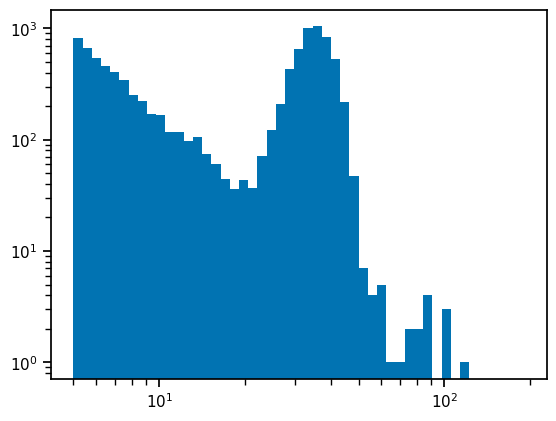

In [2]:
m_source = generate_masses(f=0.5)

plt.hist(m_source, bins=np.logspace(np.log10(min(m_source)), np.log10(max(m_source)), 50))
plt.yscale('log')
plt.xscale('log')

<AxesSubplot:ylabel='Density'>

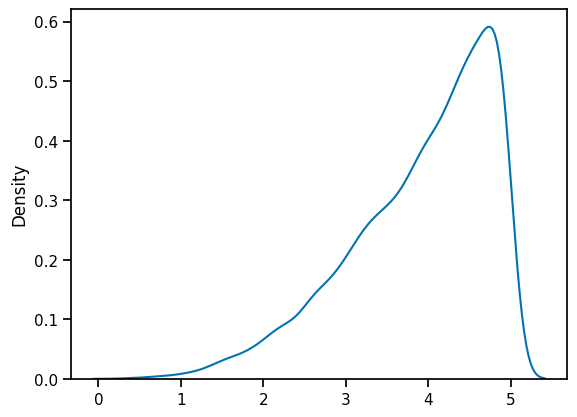

In [3]:
dLs = generate_dLs()
zs = dLs_to_zs(dLs)
m_det = m_source*(1+zs)
sns.kdeplot(zs)

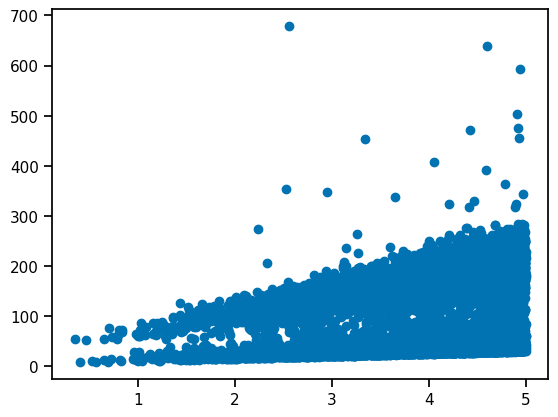

In [4]:
plt.scatter(zs, m_det)

## Ok, now let's try making a double model...
* One distribution keeps the same bump as what's been tried (gaussian~$35M_\odot$)
* Add new distribution trying to account for redshifted BHs in the exponential

Current attempt: model's job is to sort which BHs are on gaussian and isolate them from rest of sample, then perform inference on just those

_pretend we only have detector frame data for now_

In [9]:
with pm.Model() as sorter_model:

    ### bump distribution:
    m_0 = pm.Normal("m_0", mu=35, sigma=5)

    ### exponential distribution
    P_exp = pm.Beta("P_exp", alpha=1, beta=1) #prior that any point is in exponential
    m_exp = pm.Exponential("m_exp", lam=-2.35)

    ms_true = pm.Deterministic('ms_true', m_0*(1+zs))
    
    logp_bump = at.log1p(-P_exp) + pm.logp(pm.Normal.dist(mu=ms_true, sigma=ms_true/(100)), m_det)
    logp_exp = at.log(P_exp) + pm.logp(pm.Exponential.dist(lam=-2.35), m_det)

    log_odds = pm.Deterministic('log_odds', logp_bump - logp_exp)
    _ = pm.Potential('likelihood', at.sum(pm.logaddexp(logp_bump, logp_exp)))


In [17]:
print(sorter_model['log_odds'].shape)
P_bump = array(np.mean(1/(1+exp(-sorter_model['log_odds']))))

for i in range(len(m_det)):
    plot(zs[i], m_det[i], 'b.', alpha=P_bump[i])

Shape.0


TypeError: mean() got an unexpected keyword argument 'out'